# RIW Project by Cécile Gontier and Delphine Shi
This notebook will demonstrate primary results from the project.

## Part 1 : Pre-processing the copus

### CACM
Calculate tokens and vocabulary size for CACM collection, the Heap law regression, and draw its frequency-rank graph.

2019-02-22 09:35:45,235 - INFO : Start building index...
2019-02-22 09:35:45,931 - INFO : Index built in 0.6931798458099365 seconds


Tokens: 188887
Vocabulary: 9238

(b, k) = (0.4736822683077262, 29.264061028536908)
For 1 million tokens there would be (by Heap law) 20343.618531559812 vocabulary


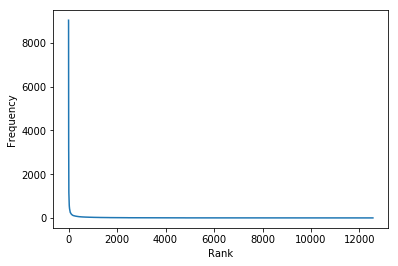

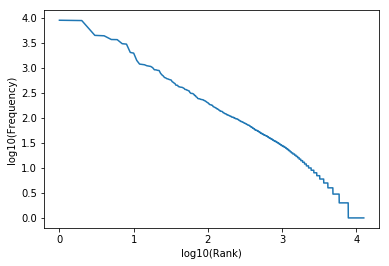

In [2]:
from CACMIndex import *
from heapRegression import *

cacmindex = CACMIndex()
cacmindex.build()
cacmindex.get_size()

print()
#following data is the result of size number for full and half text.
CACM_tokens = np.array([188887, 85151])
CACM_vocab = np.array([9238, 6334])
heap = HeapRegression(CACM_tokens, CACM_vocab)
parameters = heap.calculate_regression()
print("The Heap law parameters are:")
print("(b, k) = {}".format(parameters))
print("For 1 million tokens there would be (by Heap law) {} vocabulary"
    .format(heap.calculate_vocab(1000000, parameters)))

graph = FrequencyRankGraph(cacmindex.get_freq())
graph.draw_graph()
graph.draw_log_graph()

### CS276
Calculate tokens and vocabulary size for CS276 collection, and draw its frequency-rank graph.
It will take around 10 minutes.

2019-02-22 09:35:52,607 - INFO : Start building index...
2019-02-22 09:36:00,095 - INFO : Read 1/10 folders
2019-02-22 09:36:07,552 - INFO : Read 2/10 folders
2019-02-22 09:36:15,604 - INFO : Read 3/10 folders
2019-02-22 09:36:23,823 - INFO : Read 4/10 folders
2019-02-22 09:36:31,088 - INFO : Read 5/10 folders
2019-02-22 09:36:37,771 - INFO : Read 6/10 folders
2019-02-22 09:36:45,510 - INFO : Read 7/10 folders
2019-02-22 09:36:53,492 - INFO : Read 8/10 folders
2019-02-22 09:37:01,299 - INFO : Read 9/10 folders
2019-02-22 09:37:07,801 - INFO : Read 10/10 folders
2019-02-22 09:49:46,946 - INFO : Index built in 834.3151209354401 seconds


Tokens: 25527977
Vocabulary: 284418
(b, k) = (1.019499146415413, 0.007989326705203473)
For 1 million tokens there would be (by Heap law) 10459.358754509645 vocabulary


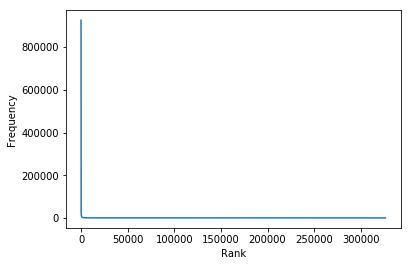

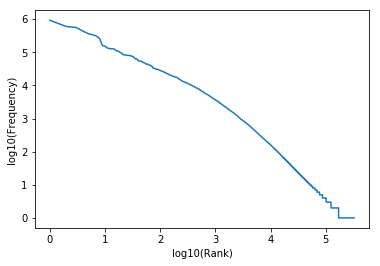

In [3]:
from CS276Index import *
from heapRegression import *

cs276index = CS276Index()
cs276index.build()
# cs276index.get_size()

print()
#following data is the result of size number for full and half text.
CS276_tokens = np.array([25527977,  12796571])
CS276_vocab = np.array([284418, 140665])
heap = HeapRegression(CS276_tokens, CS276_vocab)
parameters = heap.calculate_regression()
print("The Heap law parameters are:")
print("(b, k) = {}".format(parameters))
print("For 1 million tokens there would be (by Heap law) {} vocabulary"
    .format(heap.calculate_vocab(1000000, parameters)))

graph = FrequencyRankGraph(cs276index.get_freq())
graph.draw_graph()
graph.draw_log_graph()

## Part 2 : Inverted index
### CACM
Let's create CACM inverted index

In [9]:
from BSBIndex import *

CACMIndex = CACMIndex()
CACMIndex.build()
index = BSBIndex('CACM', CACMIndex.get_term_dict(), CACMIndex.get_document_dict())
index.build()
# print(index.get_index())

2019-02-22 10:34:36,440 - INFO : Start building index...
2019-02-22 10:34:37,106 - INFO : Index built in 0.6636819839477539 seconds


## Part 3 : Search
### Boolean search

In [6]:
from boolean.booleanEvaluation import *

# search for documents having words arithmetic and hardware in CACM collection
request_and = BooleanRequest(Operation.AND, "arithmetic", "hardware")  # 1258, 1409, 2175, 3131
model = BooleanEvaluation(request_and, "CACM")
res = model.search()
print(res)
model.display_results(res, len(res))


# here do it with CS276

[1258, 1409, 2175, 3131]
1258
An Extended Arithmetic Package In many fields, for example algebraic number
theory, arithmetic must be carried out to a degree 
of precision which exceeds the normal hardware capacity
of most machines.  In such cases, an extended 
arithmetic package provides a comprehensive and easy-to-use
way of performing such arithmetic.  Such 
a package was coded for the IBM 7090.  In discussing
the general problems associated with the design 
of an extended arithmetic package, specific reference is made to this program.


1409
NEBULA: A Digital Computer Using a 20 Mc Glass Delay Line Memory Oregon State University has designed and constructed
a medium-speed serial digital computer 
using glass delay lines circulating at 22 Mc as memory.
 The design objectives as originally conceived 
in a special seminar were: (1) to be a research project
in computer design; (2) to be usable as an educational 
machine;and (3) to have easily modifiable hardware for
basic research in co

### Vectorial search

In [13]:
from vectorial.vectorialEvaluation import *

# in CACM collection
request = "arithmetic hardware"
model = VectorialEvaluation(request, "CACM")
# results, total = model.search(NaturalWeighting())
# results, total = model.search(TfIdfWeighting())
results, total = model.search(NormalizedTfIdfWeighting(), "jaccard")
# print(results)
model.display_results(results, total)

# here do it with CS276

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.7964971049053391, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.6553542616111899, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.7964971049053391, 1, 1, 1, 1, 0.7964971049053391, 1, 1, 1, 1, 1, 1, 1, 0.7964971049053391, 1, 1, 1, 1, 1, 1, 1, 1, 0.7964971049053391, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.6982975958707573, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## Part 4 : CACM Evaluation

In [ ]:
# here include performance and graphs

## Part 4 : CS276 Variable Byte